https://chat.deepseek.com/a/chat/s/b693a3a0-dd59-4cc2-b6b7-67484f101d65

In [1]:
from data_loader import load_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

### 1. Load the data from data `data_loader`:

In [3]:
df = load_data()
df.head(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


### 2. EDA:

In [4]:
print(f"There are total of {df.shape[0]} samples and {df.shape[1]} features.")

There are total of 7043 samples and 21 features.


`customer_id` won't be relevant for us, so for now we will drop it.

In [5]:
df = df.drop(columns=['customer_id'])

In [6]:
df.shape

(7043, 20)

In [7]:
df.isna().sum()

gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

We don't have any missing values.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             7043 non-null   object
 1   senior_citizen     7043 non-null   int64 
 2   partner            7043 non-null   object
 3   dependents         7043 non-null   object
 4   tenure             7043 non-null   int64 
 5   phone_service      7043 non-null   object
 6   multiple_lines     7043 non-null   object
 7   internet_service   7043 non-null   object
 8   online_security    7043 non-null   object
 9   online_backup      7043 non-null   object
 10  device_protection  7043 non-null   object
 11  tech_support       7043 non-null   object
 12  streaming_tv       7043 non-null   object
 13  streaming_movies   7043 non-null   object
 14  contract           7043 non-null   object
 15  paperless_billing  7043 non-null   object
 16  payment_method     7043 non-null   object


#### 2.1 Univariate Analysis:

In [9]:
df.value_counts('churn')

churn
No     5174
Yes    1869
Name: count, dtype: int64

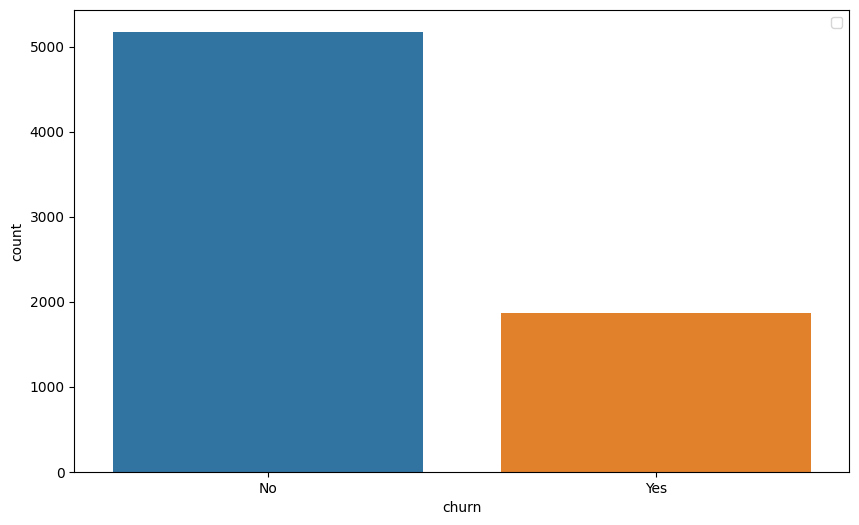

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='churn', hue='churn')
plt.legend()  
plt.show()

There is an imbalance in the dataset.

So, we will be using this dataset of 3 versions i.e.:
1. The original format
2. Undersampling (Bring down the data of high label count to low label coun)
3. Oversampling (Increase the data of low label count to match the count of the data of the high label.)

and then compare the accuracies and move forward accordingly.

In [11]:
df.head(2)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


Converting data types for `monthly_charges` and `total_charges`:

In [12]:
df['monthly_charges'] = pd.to_numeric(df['monthly_charges'], errors='coerce')
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

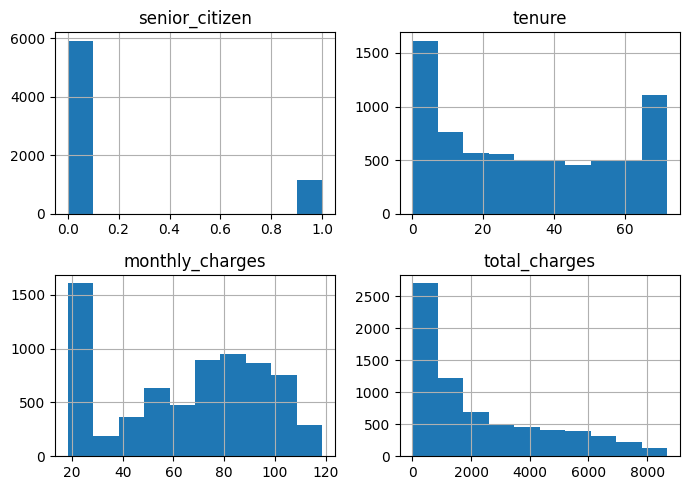

In [13]:
df.hist(figsize=(7, 5))
plt.tight_layout()
plt.show()

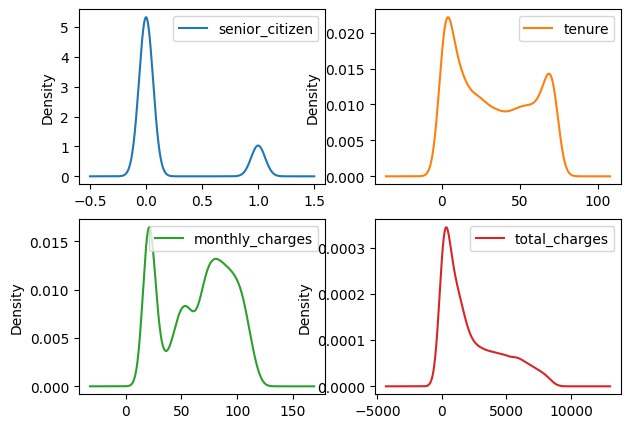

In [14]:
df.plot(kind='density', subplots=True, layout=(2, 2), figsize=(7, 5), sharex=False)
plt.show()

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
LogisticRegression()._get_tags()

{'array_api_support': False,
 'non_deterministic': False,
 'requires_positive_X': False,
 'requires_positive_y': False,
 'X_types': ['2darray'],
 'poor_score': False,
 'no_validation': False,
 'multioutput': False,
 'allow_nan': False,
 'stateless': False,
 'multilabel': False,
 '_skip_test': False,
 '_xfail_checks': False,
 'multioutput_only': False,
 'binary_only': False,
 'requires_fit': True,
 'preserves_dtype': [numpy.float64],
 'requires_y': True,
 'pairwise': False}

In [17]:
from pycaret.classification import *

ModuleNotFoundError: No module named 'pycaret'